In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import timeit
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from ordered_set import OrderedSet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
# Functions from hand on 1
def get_and_clean_data():
    data = pd.read_csv('../Week 1/resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' '*len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

def simple_tokenize(data):
    cleaned_description = data.apply(lambda s: [x.strip() for x in s.split()])
    return cleaned_description

def parse_job_description():
    cleaned_description = get_and_clean_data()
    cleaned_description = simple_tokenize(cleaned_description)
    return cleaned_description

---
- Page 74, 75 (Hand_out 2) : Activity — performance benchmark 
    - `Set operations vs list operation in stemming`

In [4]:
# Operation setup
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from ordered_set import OrderedSet

# (Given)
def set_operation(sample_size):
    cleaned_description = get_and_clean_data()[:sample_size]

    #replace non alphabets with spaces, and collapse spaces
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

    #tokenize
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    #remove stop words
    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    #create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    #stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

    return stemmed_description

def list_operation(sample_size):
    cleaned_description = get_and_clean_data()[:sample_size]

    #replace non alphabets with spaces, and collapse spaces
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

    #tokenize
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    #remove stop words
    stop_dict = list(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: [word for word in s if word not in stop_dict])
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    #create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    #stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

    return stemmed_description


In [5]:
# Benchmark
t_set = []
t_list = []
for i in range(100, 501, 100):
    t_set.append(timeit.timeit(lambda: set_operation(i), number=1))
    t_list.append(timeit.timeit(lambda: list_operation(i), number=1))

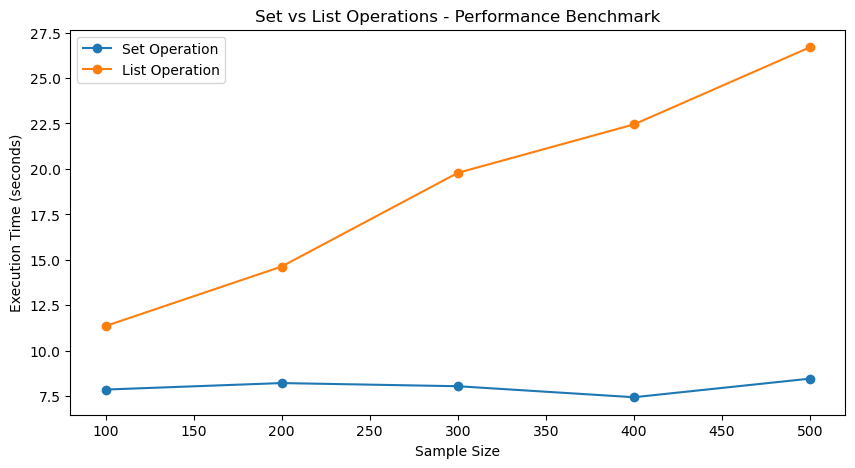

In [6]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(100, 501, 100), t_set, label='Set Operation', marker='o')
plt.plot(range(100, 501, 100), t_list, label='List Operation', marker='o')

plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Set vs List Operations - Performance Benchmark')
plt.legend()

plt.show()

- Extra: Multiprocessing

In [1]:
# Benchmark with multiprocess